In [1]:
%run center_of_mass_calculation.ipynb

In [2]:
%run 3phase_pm_engine_simulation.ipynb

In [3]:
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
import math
from tensorflow.keras import backend as K

In [4]:
df = pd.read_csv("full_df.csv", header=None)

In [5]:
data = df.to_numpy()

In [6]:
X = data[:, :29]
y = data[:, 29:] * 100

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=137)

In [8]:
X_train = tf.constant(X_train, dtype="float32")
X_test = tf.constant(X_test, dtype="float32")
y_train = tf.constant(y_train, dtype="float32")
y_test = tf.constant(y_test, dtype="float32")

In [9]:
X_train.shape

TensorShape([41783, 29])

In [10]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(100_000).batch(256)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(1000)

In [11]:
def hundred_relu(x):
    return K.relu(x, max_value=100)

In [12]:
class EvaluatorNetwork(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.hidden_layers = [
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(64, activation="relu"),
            tf.keras.layers.Dense(64, activation="relu"),
            tf.keras.layers.Dense(64, activation="relu"),
        ]
        self.output_layer = tf.keras.layers.Dense(1, activation=hundred_relu)
        
    def call(self, x):
        for layer in self.hidden_layers:
            x = layer(x)
        return self.output_layer(x)

In [44]:
evaluator = EvaluatorNetwork()

In [45]:
evaluator.build(input_shape=(None, 29))
evaluator.summary()

Model: "evaluator_network_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_1 (Batc  multiple                 116       
 hNormalization)                                                 
                                                                 
 dense_9 (Dense)             multiple                  1920      
                                                                 
 dense_10 (Dense)            multiple                  4160      
                                                                 
 dense_11 (Dense)            multiple                  4160      
                                                                 
 dense_12 (Dense)            multiple                  65        
                                                                 
Total params: 10,421
Trainable params: 10,363
Non-trainable params: 58
__________________________________________

In [46]:
loss_object = tf.keras.losses.MeanAbsoluteError()
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.0001)

In [47]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
test_loss = tf.keras.metrics.Mean(name='test_loss')

In [48]:
@tf.function
def evaluator_train_step(params, perf):
    with tf.GradientTape() as tape:
        predictions = evaluator(params, training=True)
        loss = loss_object(perf, predictions)
    gradients = tape.gradient(loss, evaluator.trainable_variables)
    optimizer.apply_gradients(zip(gradients, evaluator.trainable_variables))

    train_loss(loss)


In [49]:
@tf.function
def evaluator_test_step(params, perf):
    predictions = evaluator(params, training=False)
    t_loss = loss_object(perf, predictions)

    test_loss(t_loss)


In [50]:
EPOCHS = 500

for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    test_loss.reset_states()

    i = 0
    for params, perf in train_ds:
        evaluator_train_step(params, perf)

    for params, perf in test_ds:
        evaluator_test_step(params, perf)

    print(
        f'Epoch {epoch + 1}, '
        f'Loss: {train_loss.result()}, '
        f'Test Loss: {test_loss.result()}, '
    )


Epoch 1, Loss: 49.550174713134766, Test Loss: 44.553199768066406, 
Epoch 2, Loss: 36.43023681640625, Test Loss: 18.792016983032227, 
Epoch 3, Loss: 9.037068367004395, Test Loss: 6.459325790405273, 
Epoch 4, Loss: 6.010499000549316, Test Loss: 5.747402191162109, 
Epoch 5, Loss: 5.644608020782471, Test Loss: 5.5458784103393555, 
Epoch 6, Loss: 5.478583812713623, Test Loss: 5.405271053314209, 
Epoch 7, Loss: 5.336498737335205, Test Loss: 5.27909517288208, 
Epoch 8, Loss: 5.223412990570068, Test Loss: 5.165883541107178, 
Epoch 9, Loss: 5.0972819328308105, Test Loss: 5.064255237579346, 
Epoch 10, Loss: 5.003212928771973, Test Loss: 4.967496395111084, 
Epoch 11, Loss: 4.894778728485107, Test Loss: 4.878659725189209, 
Epoch 12, Loss: 4.810069561004639, Test Loss: 4.7971014976501465, 
Epoch 13, Loss: 4.742681503295898, Test Loss: 4.7197771072387695, 
Epoch 14, Loss: 4.653592109680176, Test Loss: 4.647558212280273, 
Epoch 15, Loss: 4.577672481536865, Test Loss: 4.581293106079102, 
Epoch 16, Los

KeyboardInterrupt: 

In [51]:
evaluator(tf.reshape(canonical_parameters, shape=(1, 29)))

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[48.44828]], dtype=float32)>

In [52]:
canonical_parameters = tf.constant(
    [25.276] * 17 + [16] * 12,
    dtype="float32"
)
canonical_parameters = tf.reshape(canonical_parameters, shape=(1, 29))

In [53]:
trans_mult = tf.constant([45] * 17 + [8] * 12, dtype="float32")
trans_add = tf.constant([5] * 17 + [16] * 12, dtype="float32")

In [54]:
class OptimizerNetwork(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.hidden_layers = [
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.Dense(64, activation="relu"),
            tf.keras.layers.Dense(32, activation="relu"),
        ]
        self.output_layer = tf.keras.layers.Dense(29, activation="sigmoid")
        
    def call(self, x):
        for layer in self.hidden_layers:
            x = layer(x)
        x = self.output_layer(x)
        x *= trans_mult
        x += trans_add
        return x

In [132]:
optimizer = OptimizerNetwork()

In [133]:
optimizer.build(input_shape=(None, 29))
optimizer.summary()

Model: "optimizer_network_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_48 (Dense)            multiple                  3840      
                                                                 
 dense_49 (Dense)            multiple                  16512     
                                                                 
 dense_50 (Dense)            multiple                  8256      
                                                                 
 dense_51 (Dense)            multiple                  2080      
                                                                 
 dense_52 (Dense)            multiple                  957       
                                                                 
Total params: 31,645
Trainable params: 31,645
Non-trainable params: 0
_________________________________________________________________


In [134]:
loss_object = tf.keras.losses.MeanAbsoluteError()
nadam = tf.keras.optimizers.Nadam(learning_rate=0.0001)

In [135]:
train_loss = tf.keras.metrics.Mean(name='train_loss')

In [136]:
@tf.function
def optimizer_train_step(params):
    with tf.GradientTape() as tape:
        predictions = optimizer(params, training=True)
        evaluation = evaluator(predictions, training=False) / 100
        loss = 1 - evaluation
    gradients = tape.gradient(loss, optimizer.trainable_variables)
    nadam.apply_gradients(zip(gradients, optimizer.trainable_variables))

    train_loss(loss)
    return predictions

In [137]:
EPOCHS = 200
possible_densities = tf.random.uniform((1, 17), minval=5, maxval=50, dtype="float32", seed=42)
params = tf.random.uniform((1, 12), minval=16, maxval=24, dtype="float32", seed=42)
params = tf.concat([possible_densities, params], axis=1)

params = tf.reshape(params, shape=(1, 29))

for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    params = optimizer_train_step(params)

    print(
        f'Epoch {epoch + 1}, '
        f'Loss: {train_loss.result()}, '
    )

Epoch 1, Loss: 0.46284377574920654, 
Epoch 2, Loss: 0.4720079302787781, 
Epoch 3, Loss: 0.4670640230178833, 
Epoch 4, Loss: 0.46666133403778076, 
Epoch 5, Loss: 0.4637908339500427, 
Epoch 6, Loss: 0.4624338150024414, 
Epoch 7, Loss: 0.4603308439254761, 
Epoch 8, Loss: 0.4576895833015442, 
Epoch 9, Loss: 0.45405858755111694, 
Epoch 10, Loss: 0.44905245304107666, 
Epoch 11, Loss: 0.4426628351211548, 
Epoch 12, Loss: 0.4371417760848999, 
Epoch 13, Loss: 0.4330097436904907, 
Epoch 14, Loss: 0.4301784038543701, 
Epoch 15, Loss: 0.4270440340042114, 
Epoch 16, Loss: 0.42470741271972656, 
Epoch 17, Loss: 0.4217052459716797, 
Epoch 18, Loss: 0.4192119836807251, 
Epoch 19, Loss: 0.41546785831451416, 
Epoch 20, Loss: 0.4122946858406067, 
Epoch 21, Loss: 0.40922510623931885, 
Epoch 22, Loss: 0.4070524573326111, 
Epoch 23, Loss: 0.4041033387184143, 
Epoch 24, Loss: 0.4028396010398865, 
Epoch 25, Loss: 0.3998422622680664, 
Epoch 26, Loss: 0.39847850799560547, 
Epoch 27, Loss: 0.3960103988647461, 
Ep

In [138]:
params

<tf.Tensor: shape=(1, 29), dtype=float32, numpy=
array([[49.94231  , 49.999985 ,  5.005673 ,  5.1826606,  5.000003 ,
        49.999695 , 49.999737 ,  5.0000687,  5.125733 , 50.       ,
         5.188297 ,  5.       ,  5.180157 , 49.998127 ,  5.       ,
         5.       ,  5.00009  , 23.999966 , 24.       , 24.       ,
        24.       , 23.984385 , 23.998886 , 16.       , 16.000551 ,
        23.999825 , 23.998434 , 16.002691 , 23.98083  ]], dtype=float32)>

(<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
 array([[-0.00350823],
        [ 0.06379493]], dtype=float32)>,
 <tf.Tensor: shape=(), dtype=float32, numpy=4.886479>)

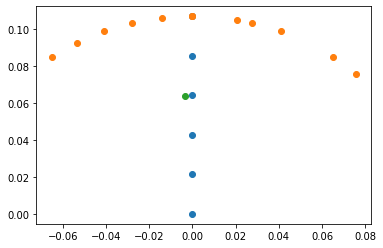

In [139]:
calculate_center_of_mass(tf.reshape(params, (29,)), show_plots=True)

In [140]:
t = np.linspace(0, 120, 1000)
evaluate_efficiency(tf.reshape(params, (29,)), t)

<tf.Tensor: shape=(), dtype=float32, numpy=0.7826712>

In [104]:
evaluate_efficiency(tf.reshape(canonical_parameters, (29,)), t)

<tf.Tensor: shape=(), dtype=float32, numpy=0.51934665>

In [159]:
d = tf.concat([tf.reshape(params, (29,)), tf.constant([0.7826712])], axis=0).numpy()
d = tf.reshape(d, shape=(30, 1))
bdf = pd.DataFrame(d)
bdf.to_csv("best_params.csv", index=False, header=False)